# Initialization
---
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [21]:
library(R.matlab)
library(seewave)
df <- readMat("~/Documents/DATA/Codes/ssPopModel/inst/sosik2003/day733320data.mat")
time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) #  fg (instead of volume)
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))

resol <- 10
dt <- resol/60
	ime.interval <- median(diff(as.numeric(colnames(V.hists))))
	ti <- as.numeric(colnames(V.hists))

	# create Light data with 'dt' time interval.
		seq <- NULL
		for(i in 1:(length(ti)-1)){
			s <- seq(ti[i], ti[i+1], length.out=1/dt)
			seq <- c(seq, s)
		}

	ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
	Einterp <- ep$y
	Einterp[Einterp < 0] <- 0


results <- readMat("~/Documents/DATA/Codes/ssPopModel/inst/sosik2003/results.mat")
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
require(DEoptim)

		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0

- $Sigma$ function for sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$


In [22]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					#sigma[,hr] <- ((N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))/TotN[hr+1]))^2 # RELATIVE observed value - fitted value
					# mean.size.pred <- sum(volbins*wt.norm)
					# mean.size.obs <-  sum(volbins*V.hists[, hr+1])
					# sd.pred <- sqrt(sum((volbins - mean.size.pred)^2)/length(volbins))
					# sd.obs <- sqrt(sum((volbins - mean.size.obs)^2)/length(volbins))
					# sigma[,hr] <- (mean.size.obs - mean.size.pred)/sqrt(sd.obs/TotN[hr+1] + sd.pred/TotN[hr+1])
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [23]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
            }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


# 1. Original model
---

## 1a. Load matrix model

In [24]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
 		c <- 0
		resp <- conv*(1.35294 * mean(y) + 0.05018) * mean(y)# proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		
  			allo <- d * (1 + volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- allo / mean(allo)
 			allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optimization 
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [25]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6, 1e-6), upper=c(1,1,15,max(Einterp),15,10), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		c <- params[5]
		d <- params[6]
		resnorm <- opt$optim$bestval


Iteration: 10 bestvalit: 5.995817 bestmemit:    0.141095    0.027337    5.872438  385.412437    6.363848    7.346694
Iteration: 20 bestvalit: 5.246373 bestmemit:    0.141966    0.028918    4.768798  226.656498    3.963738    1.184569
Iteration: 30 bestvalit: 5.026203 bestmemit:    0.153937    0.035108    3.856297  231.785182    7.461690    5.282911
Iteration: 40 bestvalit: 5.007179 bestmemit:    0.157101    0.035108    3.856297  231.785182    7.461690    2.299085
Iteration: 50 bestvalit: 4.984027 bestmemit:    0.166669    0.035438    4.043859  253.739640    9.500888    4.662296
Iteration: 60 bestvalit: 4.981813 bestmemit:    0.167176    0.035640    3.929886  253.264387    9.980790    2.496460
Iteration: 70 bestvalit: 4.977478 bestmemit:    0.166253    0.036101    4.063451  259.637128    2.951903    1.157878
Iteration: 80 bestvalit: 4.976100 bestmemit:    0.166540    0.035580    4.033845  257.694268    4.339619    0.128723
Iteration: 90 bestvalit: 4.975778 bestmemit:    0.166253    0.03

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [6]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax. <- params[1]
		dmax. <- params[2]
		b. <- params[3]
		E_star. <- params[4]
		c. <- params[5]
		d. <- params[6]
		resnorm. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.254514 bestmemit:    0.173557    0.049382    4.484547  238.607458    4.994654    1.782689
Iteration: 20 bestvalit: 0.239515 bestmemit:    0.170781    0.030080    3.979673  160.381066    7.312678    2.363705
Iteration: 30 bestvalit: 0.232435 bestmemit:    0.185917    0.038550    4.006174  269.123738    3.165191    8.228820
Iteration: 40 bestvalit: 0.230799 bestmemit:    0.167728    0.033028    3.899456  263.420893    7.374879    5.758355
Iteration: 50 bestvalit: 0.230656 bestmemit:    0.169904    0.033028    3.927003  244.647086    7.027341    7.790063
Iteration: 60 bestvalit: 0.230237 bestmemit:    0.173930    0.032968    3.912908  261.442938    6.789410    1.143734
Iteration: 70 bestvalit: 0.230098 bestmemit:    0.170800    0.032186    3.935989  260.380485    5.659754    4.584386
Iteration: 80 bestvalit: 0.229915 bestmemit:    0.170397    0.031575    3.880571  256.485482    9.464646    6.545131
Iteration: 90 bestvalit: 0.229915 bestmemit:    0.170397    0.03

## 1c. Results

In [26]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- V.hists
Nproj <- Nproj. <- N.dist
mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star,c=c, d=d, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
#       B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star.,c=c., d=d., resol=resol)
#       Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
#       Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
# 	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
# 		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
# 					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
# Nproj. <- colSums(Nproj.)
# colnames(mu_N.) <- colnames(Vproj.)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
# d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2)))#,"-",round(d.mu_N.,2)))


[1] "daily growth rate= 0.73"


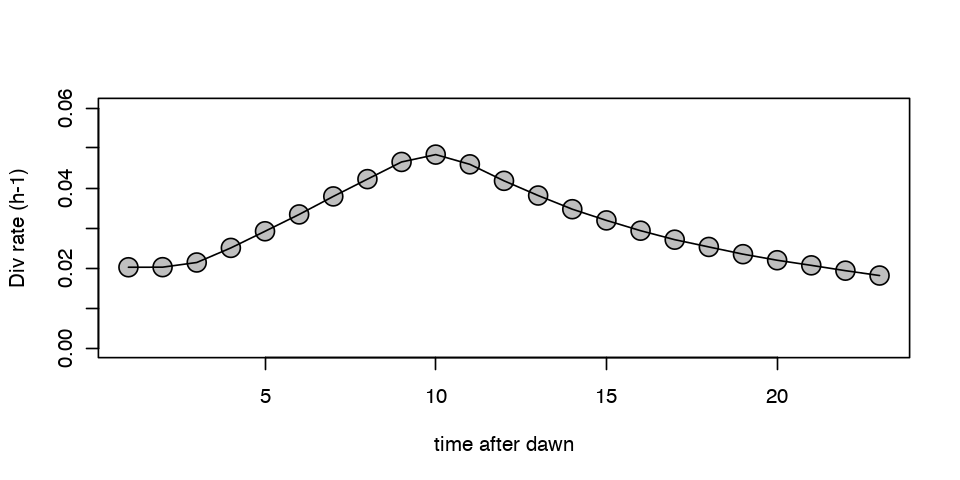

In [43]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

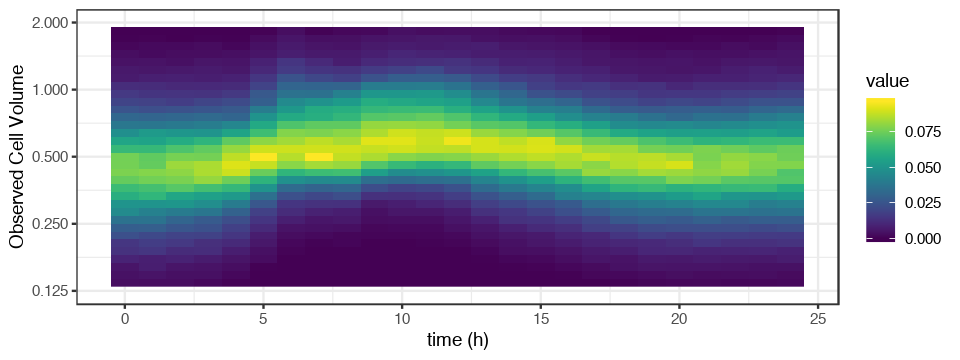

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

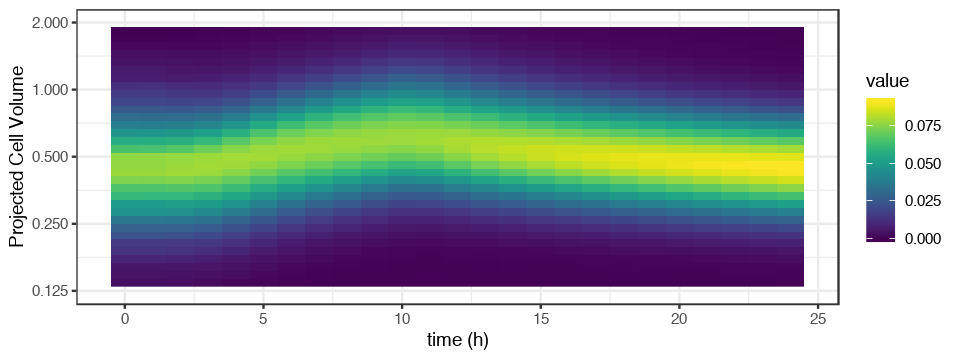

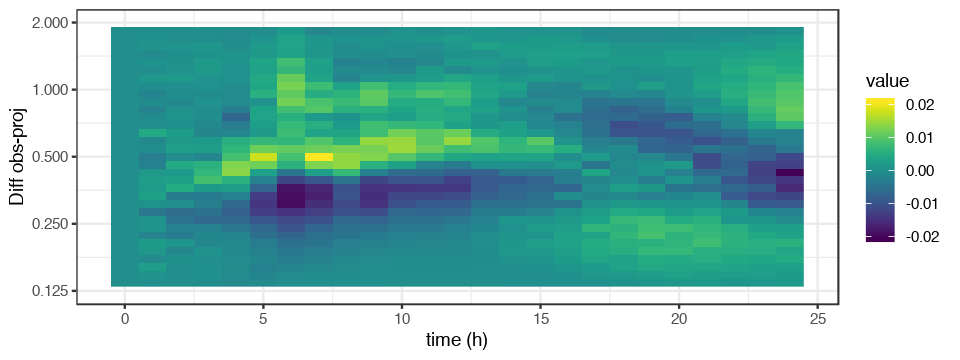

In [42]:
options(repr.plot.width=8, repr.plot.height=3)

ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

ggplot(melt(V.hists - Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradientn(colors=viridis::viridis(100))

# 2. Model with Respiration
---


## 2a. Load matrix model

In [7]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
		resp <- conv*(1.35294 * mean(y) + 0.05018) * mean(y)# proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		
  			allo <- d * (1 + volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- allo / mean(allo)
 			allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 2b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [8]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		c2 <- params[5]
		d2 <- params[6]
		resnorm2 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.361328 bestmemit:    0.078795    0.009230   11.685031  249.602865    5.689827    1.933811
Iteration: 20 bestvalit: 5.028692 bestmemit:    0.105790    0.017915    7.508040  284.169941    4.095957    6.399056
Iteration: 30 bestvalit: 4.804377 bestmemit:    0.128042    0.023369    5.261560  227.972146    2.373678    6.266734
Iteration: 40 bestvalit: 4.804377 bestmemit:    0.128042    0.023369    5.261560  227.972146    2.373678    2.145032
Iteration: 50 bestvalit: 4.777421 bestmemit:    0.131922    0.023499    5.032165  238.446184    2.174529   11.609384
Iteration: 60 bestvalit: 4.752480 bestmemit:    0.147463    0.028561    4.656584  257.847583    1.078705   14.198820
Iteration: 70 bestvalit: 4.740069 bestmemit:    0.141401    0.027415    4.577907  243.413726    1.395329    9.228188
Iteration: 80 bestvalit: 4.739258 bestmemit:    0.139336    0.025578    4.694430  249.609376    1.635984   12.135663
Iteration: 90 bestvalit: 4.737895 bestmemit:    0.145014    0.02

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [9]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2. <- params[1]
		dmax2. <- params[2]
		b2. <- params[3]
		E_star2. <- params[4]
		c2. <- params[5]
		d2. <- params[6]
		resnorm2. <- opt$optim$bestval

ERROR: Error in seewave::kl.dist(N.dist[, hr + 1], round(TotN[hr + 1] * wt.norm)): Data do not have to be in dB


## 2c. Results

In [11]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj2 <- Vproj2. <- V.hists
Nproj2 <- Nproj2. <- N.dist
mu_N2 <- mu_N2. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2, dmax=dmax2,b=b2, E_star=E_star2,c=c2, d=d2, resol=resol)
    Nproj2[,hr+1] <- round(B %*% Nproj2[,hr]) # calculate numbers of individuals
	Vproj2[,hr+1] <- B %*% Vproj2[,hr] # calculate the projected size-frequency distribution
	Vproj2[,hr+1] <- Vproj2[,hr+1]/sum(Vproj2[,hr+1]) # normalize distribution so sum = 1
	mu_N2[,hr+1] <- log(sum(Nproj2[,hr+1])/sum(Nproj2[,hr]))/
					((as.numeric(colnames(Nproj2)[hr+1])-as.numeric(colnames(Nproj2)[hr]))/(time.interval))
            		    
#   B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2., dmax=dmax2.,b=b2., E_star=E_star2.,c=c2., d=d2., resol=resol)
#   Nproj2.[,hr+1] <- round(B. %*% Nproj2.[,hr]) # calculate numbers of individuals
# 	Vproj2.[,hr+1] <- B. %*% Vproj2.[,hr] # calculate the projected size-frequency distribution
# 	Vproj2.[,hr+1] <- Vproj2.[,hr+1]/sum(Vproj2.[,hr+1]) # normalize distribution so sum = 1
# 	mu_N2.[,hr+1] <- log(sum(Nproj2.[,hr+1])/sum(Nproj2.[,hr]))/
# 					((as.numeric(colnames(Nproj2.)[hr+1])-as.numeric(colnames(Nproj2.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj2)
colnames(mu_N2) <- colnames(Vproj2)
# Nproj2. <- colSums(Nproj2.)
# colnames(mu_N2.) <- colnames(Vproj2.)

#############################
## Growth rate calculation ##
#############################
d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
# d.mu_N2. <- 24*mean(mu_N2.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N2,2)))#,"-",round(d.mu_N2.,2)))

[1] "daily growth rate= 0.48"


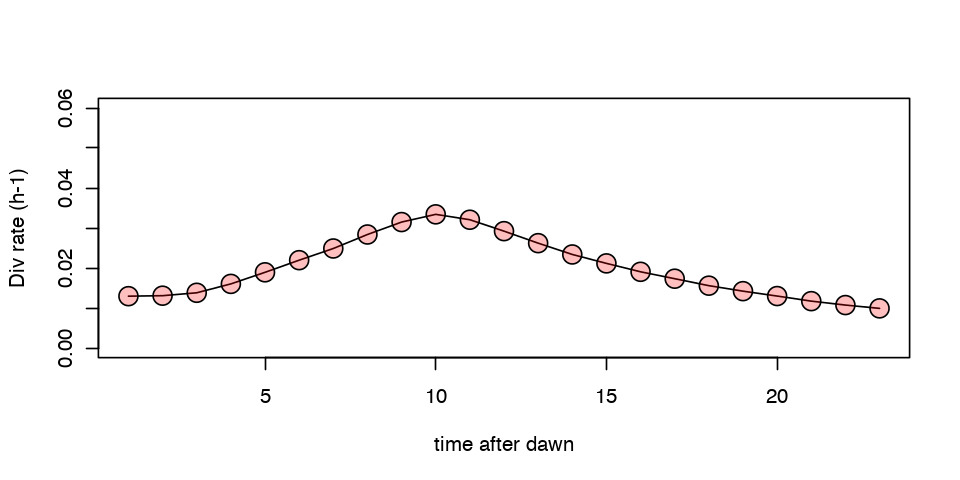

In [41]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N2[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(2,0.25))
    #points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

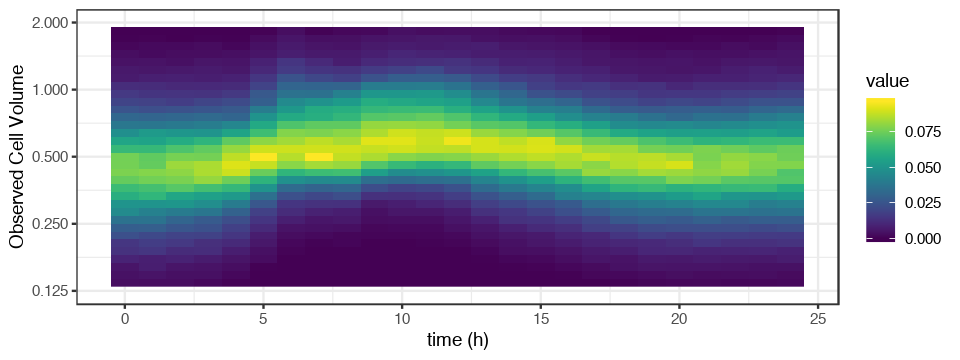

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

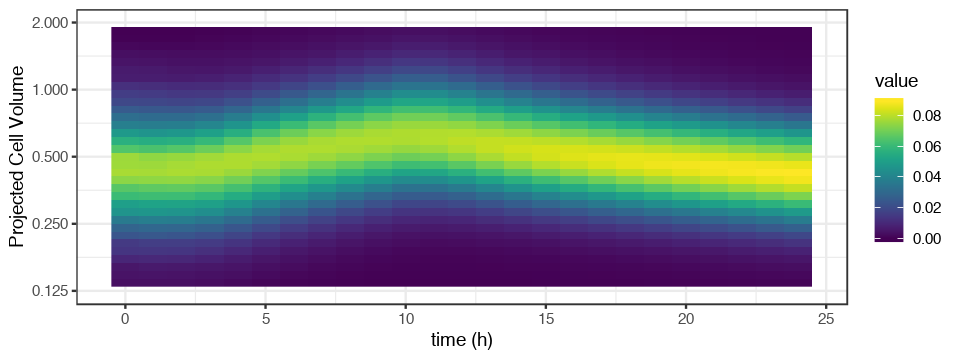

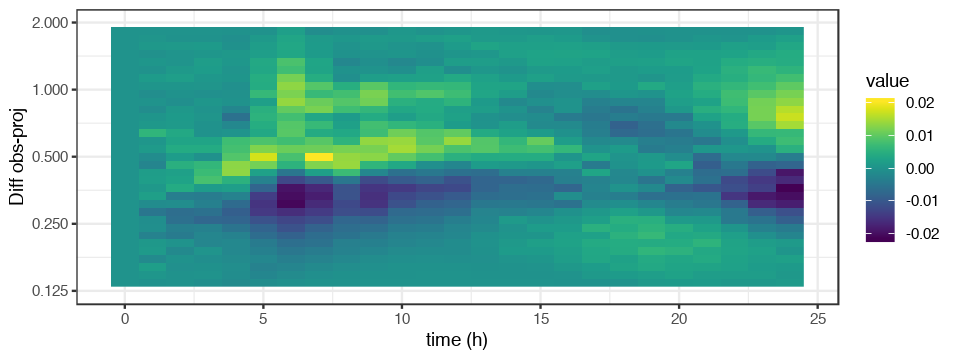

In [40]:
options(repr.plot.width=8, repr.plot.height=3)

ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

ggplot(melt(Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

ggplot(melt(V.hists - Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradientn(colors=viridis::viridis(100))

# 3 Model with Respiration + Allometric functions
---

## 3a. Load matrix model

In [14]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
		resp <- conv*(1.35294 * mean(y) + 0.05018) * mean(y)# proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		
  			allo <- d * (1 + volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- allo / mean(allo)
  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 3b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [15]:
	f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3 <- params[1]
		dmax3 <- params[2]
		b3 <- params[3]
		E_star3 <- params[4]
		c3 <- params[5]
		d3 <- params[6]
		resnorm3 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.501284 bestmemit:    0.578658    0.009858    5.056560  402.074917    1.320234    5.721315
Iteration: 20 bestvalit: 5.116539 bestmemit:    0.554656    0.014635    4.822058  276.324233    1.157624    7.179186
Iteration: 30 bestvalit: 5.097782 bestmemit:    0.522518    0.023686    3.789626  216.555196    0.683210    5.192709
Iteration: 40 bestvalit: 4.924201 bestmemit:    0.557674    0.017760    4.200158  248.789774    0.642953    0.924264
Iteration: 50 bestvalit: 4.885236 bestmemit:    0.652803    0.022057    4.071722  268.687442    0.432875    9.268533
Iteration: 60 bestvalit: 4.826412 bestmemit:    0.671889    0.020437    3.263591  254.313268    0.387979   11.520922
Iteration: 70 bestvalit: 4.826412 bestmemit:    0.671889    0.020437    3.263591  254.313268    0.387979   11.520922
Iteration: 80 bestvalit: 4.821814 bestmemit:    0.671889    0.020437    3.263591  239.924820    0.387979   13.591438
Iteration: 90 bestvalit: 4.814814 bestmemit:    0.653283    0.02

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [ ]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3. <- params[1]
		dmax3. <- params[2]
		b3. <- params[3]
		E_star3. <- params[4]
		c3. <- params[5]
		d3. <- params[6]
		resnorm3. <- opt$optim$bestval

## 3c. Results

In [17]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
print(params)

res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj3 <- Vproj3. <- V.hists
Nproj3 <- Nproj3. <- N.dist
mu_N3 <- mu_N3. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3, dmax=dmax3,b=b3, E_star=E_star3,c=c3, d=d3, resol=resol)
    Nproj3[,hr+1] <- round(B %*% Nproj3[,hr]) # calculate numbers of individuals
	Vproj3[,hr+1] <- B %*% Vproj3[,hr] # calculate the projected size-frequency distribution
	Vproj3[,hr+1] <- Vproj3[,hr+1]/sum(Vproj3[,hr+1]) # normalize distribution so sum = 1
	mu_N3[,hr+1] <- log(sum(Nproj3[,hr+1])/sum(Nproj3[,hr]))/
					((as.numeric(colnames(Nproj3)[hr+1])-as.numeric(colnames(Nproj3)[hr]))/(time.interval))
            		    
#   B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3., dmax=dmax3.,b=b3., E_star=E_star3.,c=c3., d=d3., resol=resol)
#   Nproj3.[,hr+1] <- round(B. %*% Nproj3.[,hr]) # calculate numbers of individuals
# 	Vproj3.[,hr+1] <- B. %*% Vproj3.[,hr] # calculate the projected size-frequency distribution
# 	Vproj3.[,hr+1] <- Vproj3.[,hr+1]/sum(Vproj3.[,hr+1]) # normalize distribution so sum = 1
# 	mu_N3.[,hr+1] <- log(sum(Nproj3.[,hr+1])/sum(Nproj3.[,hr]))/
# 					((as.numeric(colnames(Nproj3.)[hr+1])-as.numeric(colnames(Nproj3.)[hr]))/(time.interval))
						
    }

Nproj3 <- colSums(Nproj3)
colnames(mu_N3) <- colnames(Vproj3)
# Nproj3. <- colSums(Nproj3.)
# colnames(mu_N3.) <- colnames(Vproj3.)
		
#############################
## Growth rate calculation ##
#############################
d.mu_N3 <- 24*mean(mu_N3[-c(1:2)], na.rm=T)
# d.mu_N3. <- 24*mean(mu_N3.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N3,2)))#,"-",round(d.mu_N3.,2)))

        par1         par2         par3         par4         par5         par6 
  0.66807004   0.02156155   3.36265586 254.51939412   0.35842551   9.32308352 
[1] "daily growth rate= 0.48"


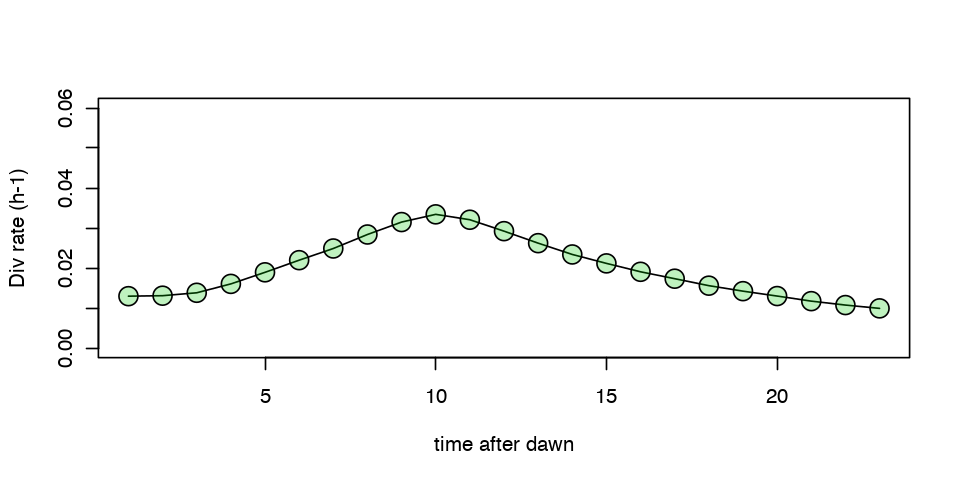

In [39]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N2[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(3,0.25))
    #points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

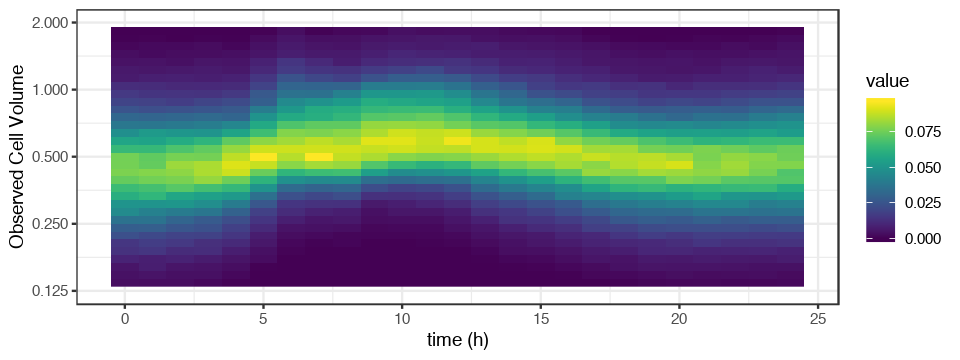

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

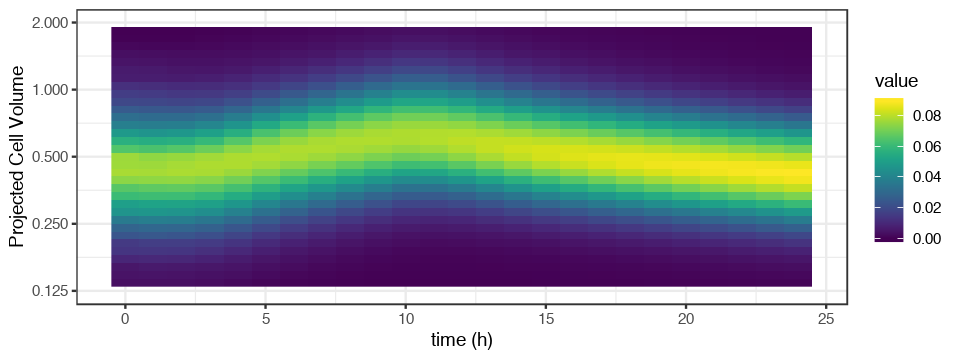

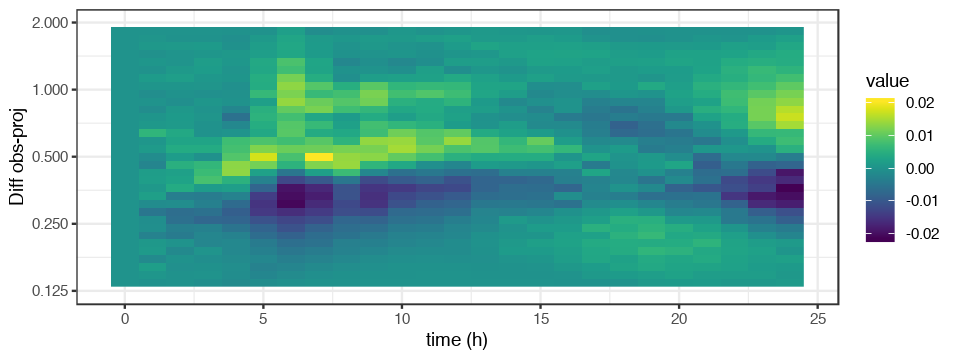

In [37]:
options(repr.plot.width=8, repr.plot.height=3)

ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

ggplot(melt(Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

ggplot(melt(V.hists - Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradientn(colors=viridis::viridis(100))

# 4. Summary
---

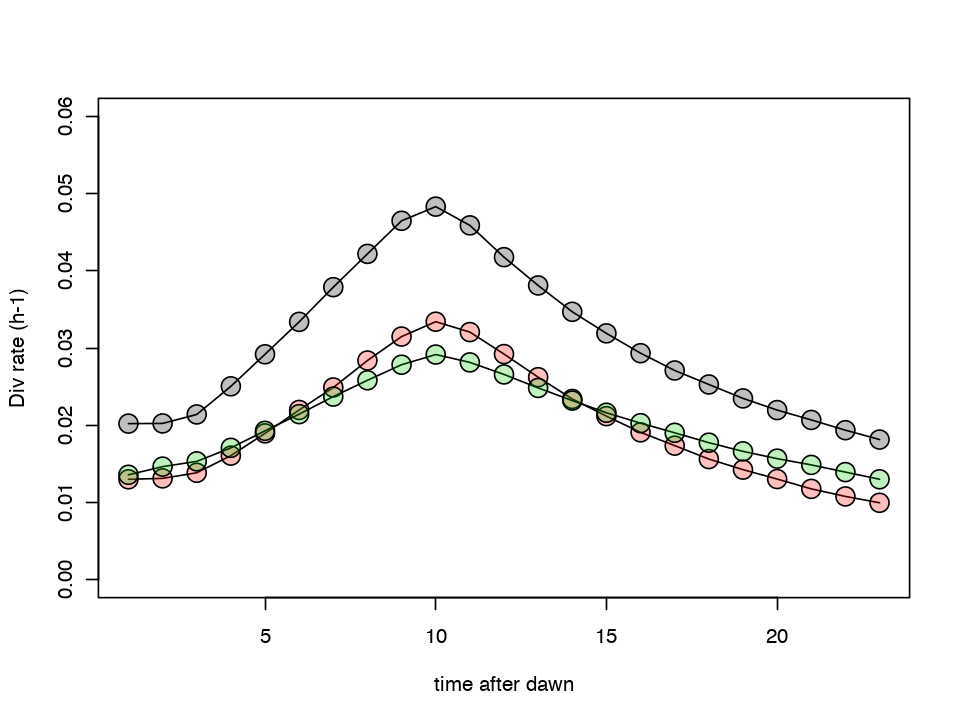

In [44]:
options(repr.plot.width=8, repr.plot.height=6)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
  #  points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
  points(mu_N2[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
  #  points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))
  points(mu_N3[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.25))
  #  points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.5))
